In [58]:
# Imports 

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
# Splitting the data 

train_data = tf.keras.utils.image_dataset_from_directory(
    directory='data',
    label_mode=None,
    batch_size=32,
    image_size=(64, 64),
    validation_split=0.2,
    subset="training",
    seed=123)

test_data = tf.keras.utils.image_dataset_from_directory(
    directory='data',
    label_mode=None,
    batch_size=32,
    image_size=(64, 64),
    validation_split=0.2,
    subset="validation",
    seed=123)

Found 17534 files belonging to 1 classes.
Using 14028 files for training.
Found 17534 files belonging to 1 classes.
Using 3506 files for validation.


In [111]:
# Data Preprocessing

norm = layers.Rescaling(scale=1./255)

def noise(array):
    noise_factor = 0.4
    noisy_array = array + noise_factor * tf.random.normal(shape = array.shape, mean=0, stddev=1, dtype=tf.dtypes.float32)
    return tf.clip_by_value(noisy_array, 0, 1)

norm_train_data = train_data.map(lambda x: norm(x))
noise_train_data = norm_train_data.unbatch().map(lambda x: (noise(x), x))
noise_train_data = noise_train_data.batch(32)

norm_test_data = test_data.map(lambda x: norm(x))
noise_test_data = norm_test_data.unbatch().map(lambda x: (noise(x), x))
noise_test_data = noise_test_data.batch(32)

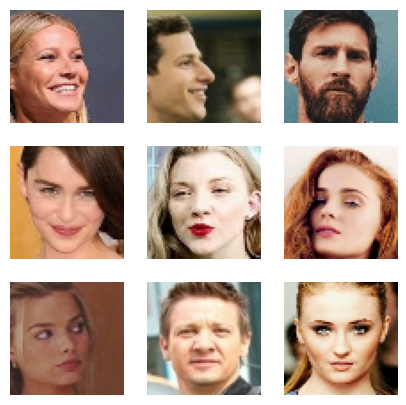

In [113]:
plt.figure(figsize=(5, 5))
for images in noise_train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[1][i].numpy().astype("float32"))
        plt.axis("off")

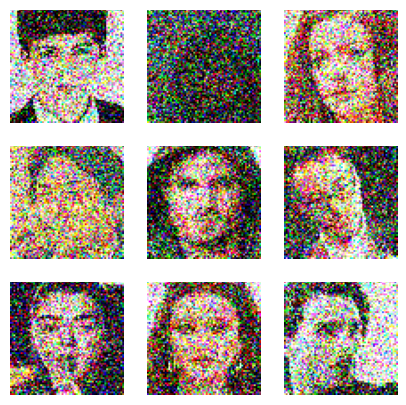

In [114]:
plt.figure(figsize=(5, 5))
for images in noise_train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[0][i].numpy().astype("float32"))
        plt.axis("off")

In [115]:
input = layers.Input(shape=(64, 64, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_transpose_14 (Conv2  (None, 32, 32, 32)        9248

In [116]:
autoencoder.fit(
    x = noise_train_data,
    epochs=100,
    batch_size=32,
    shuffle=True, 
    validation_data=noise_test_data
)

Epoch 1/100


439/439 [==============================] - 8s 14ms/step - loss: 0.5431 - val_loss: 0.5273
Epoch 2/100
439/439 [==============================] - 6s 14ms/step - loss: 0.5257 - val_loss: 0.5255
Epoch 3/100
439/439 [==============================] - 6s 14ms/step - loss: 0.5244 - val_loss: 0.5245
Epoch 4/100
439/439 [==============================] - 6s 14ms/step - loss: 0.5236 - val_loss: 0.5238
Epoch 5/100
439/439 [==============================] - 6s 14ms/step - loss: 0.5231 - val_loss: 0.5236
Epoch 6/100
439/439 [==============================] - 6s 14ms/step - loss: 0.5228 - val_loss: 0.5230
Epoch 7/100
439/439 [==============================] - 6s 14ms/step - loss: 0.5224 - val_loss: 0.5230
Epoch 8/100
439/439 [==============================] - 6s 14ms/step - loss: 0.5222 - val_loss: 0.5227
Epoch 9/100
439/439 [==============================] - 6s 14ms/step - loss: 0.5219 - val_loss: 0.5227
Epoch 10/100
439/439 [==============================] - 6s 14ms/step - loss: 0.5216 - val_loss

In [117]:
predictions = autoencoder.predict(noise_test_data)

110/110 [==============================] - 1s 9ms/step


In [119]:
predictions.shape

(3506, 64, 64, 3)

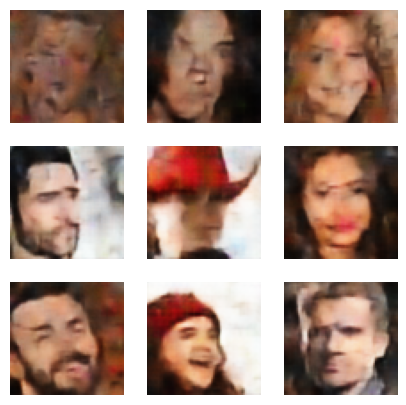

In [121]:
plt.figure(figsize=(5, 5))
for img in range(9):
    ax = plt.subplot(3, 3, img + 1)
    plt.imshow(predictions[img])
    plt.axis("off")

1/1 [==============================] - 0s 16ms/step
36


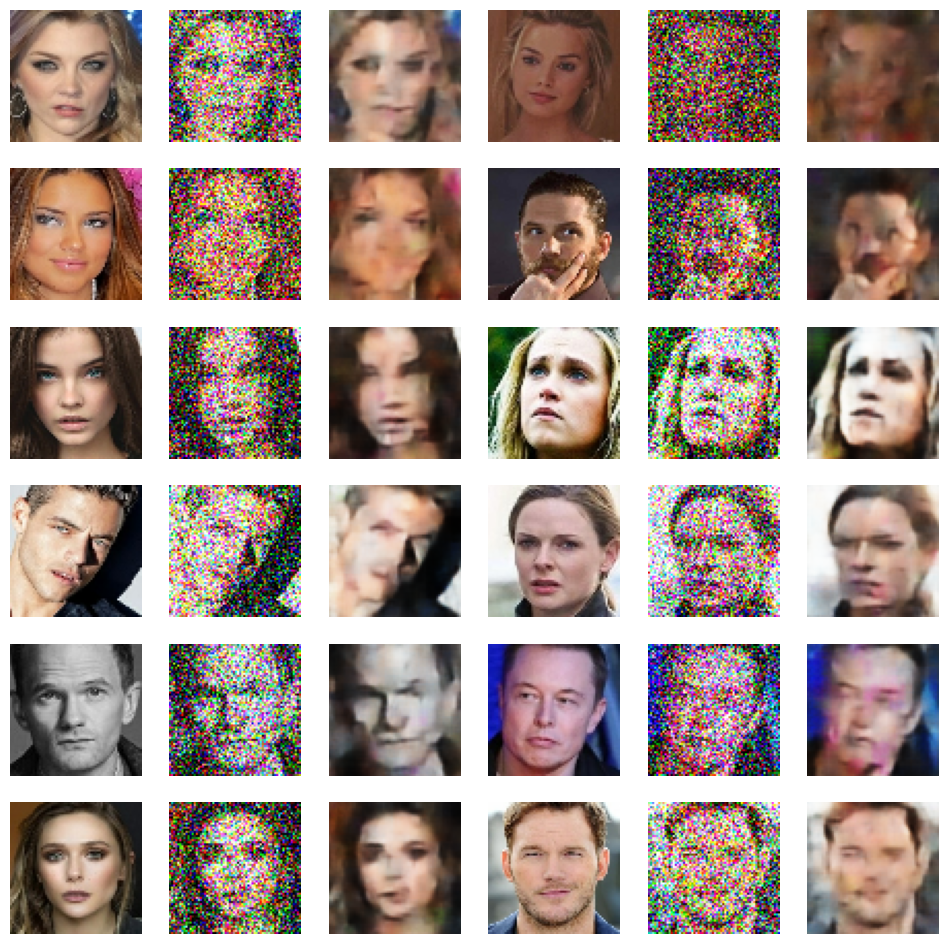

In [152]:
plt.figure(figsize=(12, 12))
for img in noise_test_data.take(1):
    val = img[0]
    prediction = autoencoder.predict(val)
    count = 0
    for i in range(12):
        ax = plt.subplot(6, 6, count + 1)
        plt.imshow(img[1][i])
        plt.axis("off")
        count = count + 1
        ax = plt.subplot(6, 6, count + 1)
        plt.imshow(img[0][i])
        plt.axis("off")
        count = count + 1
        ax = plt.subplot(6, 6, count + 1)
        plt.imshow(prediction[i])
        plt.axis("off")
        count = count + 1
    print(count)
